#Fraud Predcition using Graph Neural Networks

In [1]:
import pandas as pd
df = pd.read_csv('/content/data (1).csv')

In [2]:
!pip install ace_tools_open

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.2 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [3]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 30.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.6/886.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.3 MB/s eta 0:00:00


In [5]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
df['Filing Date'] = pd.to_datetime(df['Filing Date'], errors='coerce', dayfirst=True)
df['Registration Date'] = pd.to_datetime(df['Registration Date'], errors='coerce', dayfirst=True)
df['First Hearing Date'] = pd.to_datetime(df['First Hearing Date'], errors='coerce', dayfirst=True)
df['Decision Date'] = pd.to_datetime(df['Decision Date'], errors='coerce', dayfirst=True)

df['Case Duration'] = (df['Decision Date'] - df['Filing Date']).dt.days

label_encoder = LabelEncoder()
df['Case Status Encoded'] = label_encoder.fit_transform(df['Case Status'].fillna('Unknown'))
df['Nature of Disposal Encoded'] = label_encoder.fit_transform(df['Nature of Disposal'].fillna('Unknown'))
df['Under Act Encoded'] = label_encoder.fit_transform(df['Under Act'].fillna('Unknown'))

df['Case Duration'] = df['Case Duration'].fillna(df['Case Duration'].median())

df_cleaned = df[['Case Duration', 'Case Status Encoded', 'Nature of Disposal Encoded', 'Under Act Encoded']]
df_cleaned = df_cleaned.dropna()
df_cleaned['Fraud'] = np.where(df['Nature of Disposal'].str.contains('LOKADALAT', case=False, na=False), 1, 0)
# import ace_tools_open as tools; tools.display_dataframe_to_user(name="Preprocessed Insurance Fraud Detection Dataset", dataframe=df_cleaned)

##FEATURE ANALYSIS

Case Duration: Fraudulent cases may have different timelines compared to legitimate ones

Case Status Encoded: Certain case statuses may occur more frequently in fraudulent cases, which could help differentiate between fraud and non-fraud.

Nature of Disposal Encoded: If a high number of cases are disposed of under LOKADALAT or other rapid-settlement methods, it might indicate fraudulent patterns.

Under Act Encoded: Certain acts may have a higher incidence of fraud, which can be detected by analyzing how frequently these acts are associated with fraudulent cases.


<ipython-input-11-5d8f918d2a90>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Fraud', y='Case Duration', data=df_cleaned, palette='Set1')


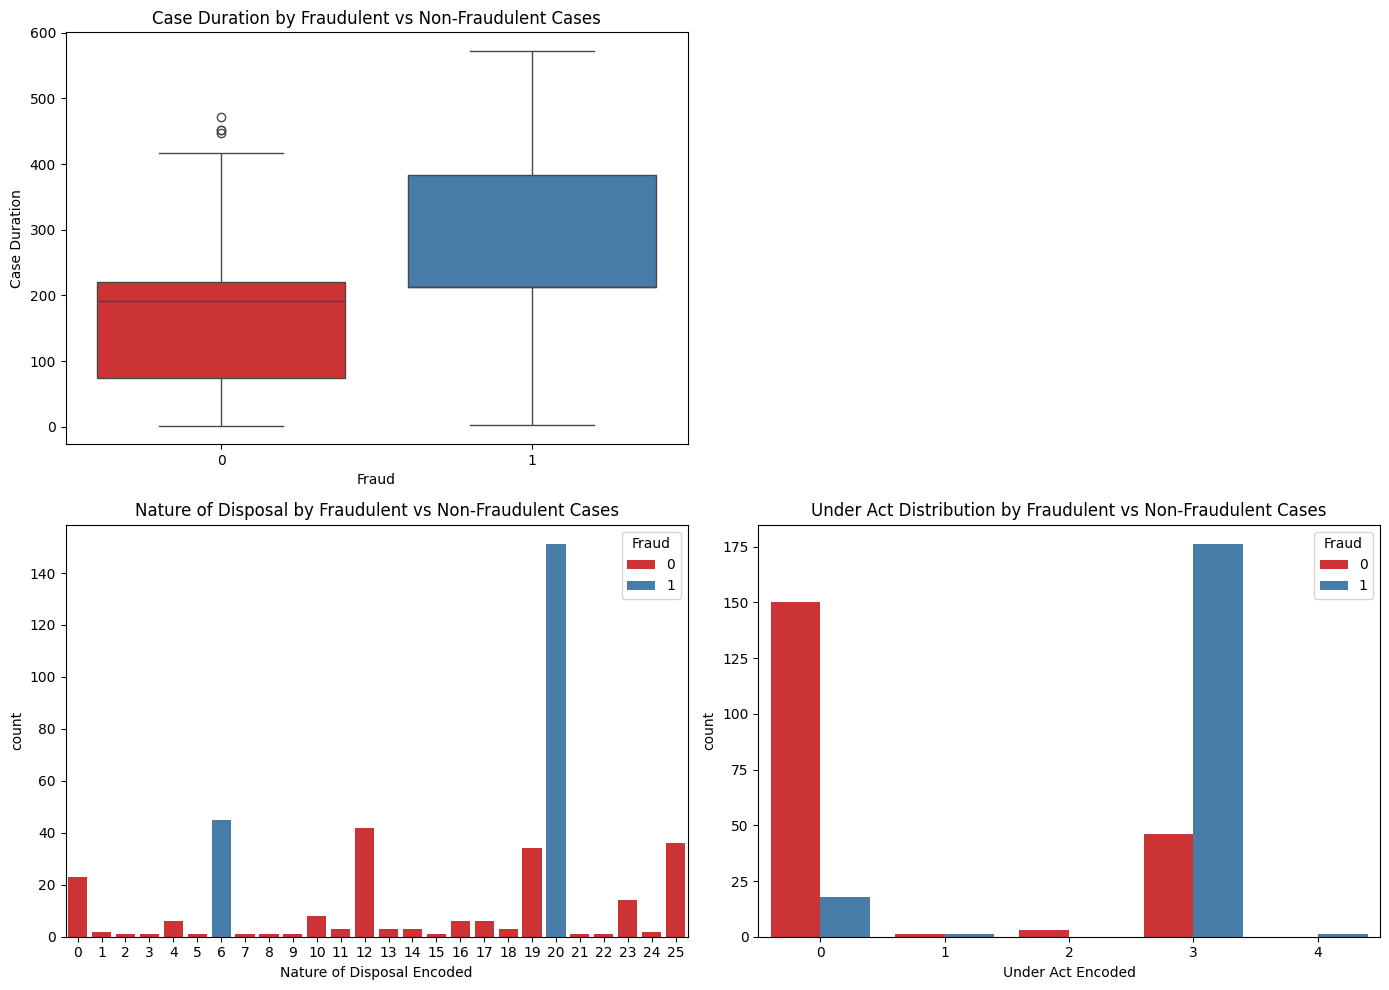

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='Fraud', y='Case Duration', data=df_cleaned, palette='Set1')
plt.title('Case Duration by Fraudulent vs Non-Fraudulent Cases')

plt.subplot(2, 2, 3)
sns.countplot(x='Nature of Disposal Encoded', hue='Fraud', data=df_cleaned, palette='Set1')
plt.title('Nature of Disposal by Fraudulent vs Non-Fraudulent Cases')

plt.subplot(2, 2, 4)
sns.countplot(x='Under Act Encoded', hue='Fraud', data=df_cleaned, palette='Set1')
plt.title('Under Act Distribution by Fraudulent vs Non-Fraudulent Cases')

plt.tight_layout()
plt.show()

##We represent are data as a graph where each case can be treated as a node and edges represent connections based on shared attributes

In [6]:
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

G = nx.Graph()

for i, row in df_cleaned.iterrows():
    G.add_node(i,
               Case_Duration=row['Case Duration'],
               Case_Status_Encoded=row['Case Status Encoded'],
               Nature_of_Disposal_Encoded=row['Nature of Disposal Encoded'],
               Under_Act_Encoded=row['Under Act Encoded'])

for i in range(len(df_cleaned)):
    for j in range(i + 1, len(df_cleaned)):
        if df_cleaned['Under Act Encoded'].iloc[i] == df_cleaned['Under Act Encoded'].iloc[j]:
            G.add_edge(i, j)

graph_data = from_networkx(G)
graph_data.x = torch.tensor(df_cleaned[['Case Duration', 'Case Status Encoded', 'Nature of Disposal Encoded', 'Under Act Encoded']].values, dtype=torch.float)
graph_data.y = torch.tensor(df_cleaned['Fraud'].values, dtype=torch.long)

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

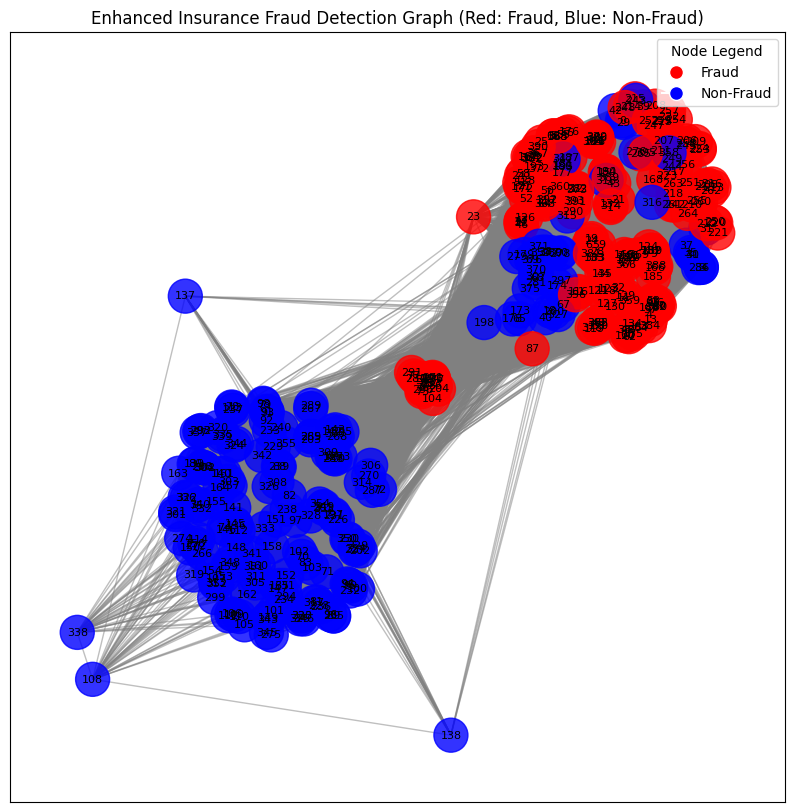

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

color_map = []
for node in graph_data.y:
    if node == 1:
        color_map.append('red')  # Fraud cases
    else:
        color_map.append('blue')  # Non-fraud cases

for i in range(len(df_cleaned)):
    for j in range(i + 1, len(df_cleaned)):
        if df_cleaned['Under Act Encoded'].iloc[i] == df_cleaned['Under Act Encoded'].iloc[j] or \
           df_cleaned['Nature of Disposal Encoded'].iloc[i] == df_cleaned['Nature of Disposal Encoded'].iloc[j]:
            G.add_edge(i, j)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=600, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

legend_labels = {'red': 'Fraud', 'blue': 'Non-Fraud'}
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_labels],
           labels=list(legend_labels.values()), title="Node Legend", loc='best')

plt.title("Enhanced Insurance Fraud Detection Graph (Red: Fraud, Blue: Non-Fraud)")
plt.show()

##A Graph Neural Network (GNN) is used to learn from this graph structure, and nodes (cases) can be classified as fraudulent or non-fraudulent based on learned representations.

In [8]:
class GNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GNN(num_node_features=4, num_classes=2)

In [12]:
num_nodes = graph_data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_size = int(0.8 * num_nodes)
train_indices = np.random.choice(num_nodes, train_size, replace=False)
test_indices = np.setdiff1d(np.arange(num_nodes), train_indices)

train_mask[train_indices] = True
test_mask[test_indices] = True

graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(graph_data)
    loss = loss_fn(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model.eval()
pred = model(graph_data).argmax(dim=1)
correct = (pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]).sum()
accuracy = int(correct) / int(graph_data.test_mask.sum())
print(f'Accuracy: {accuracy:.4f}')

Epoch 1, Loss: 0.47110414505004883
Epoch 2, Loss: 6.431073188781738
Epoch 3, Loss: 1.544905185699463
Epoch 4, Loss: 2.2857553958892822
Epoch 5, Loss: 4.000998020172119
Epoch 6, Loss: 4.101240634918213
Epoch 7, Loss: 3.1179914474487305
Epoch 8, Loss: 1.4870039224624634
Epoch 9, Loss: 0.48372727632522583
Epoch 10, Loss: 2.215228796005249
Epoch 11, Loss: 2.7377583980560303
Epoch 12, Loss: 1.879494547843933
Epoch 13, Loss: 0.5137701630592346
Epoch 14, Loss: 0.8665857315063477
Epoch 15, Loss: 1.5193376541137695
Epoch 16, Loss: 1.7695670127868652
Epoch 17, Loss: 1.521416425704956
Epoch 18, Loss: 0.9731887578964233
Epoch 19, Loss: 0.5140883326530457
Epoch 20, Loss: 0.7990877032279968
Epoch 21, Loss: 1.2618043422698975
Epoch 22, Loss: 0.9209035634994507
Epoch 23, Loss: 0.47626832127571106
Epoch 24, Loss: 0.6504746675491333
Epoch 25, Loss: 0.8788537383079529
Epoch 26, Loss: 0.9445715546607971
Epoch 27, Loss: 0.8189529180526733
Epoch 28, Loss: 0.6008610129356384
Epoch 29, Loss: 0.478817373514175

####Node embeddings are created

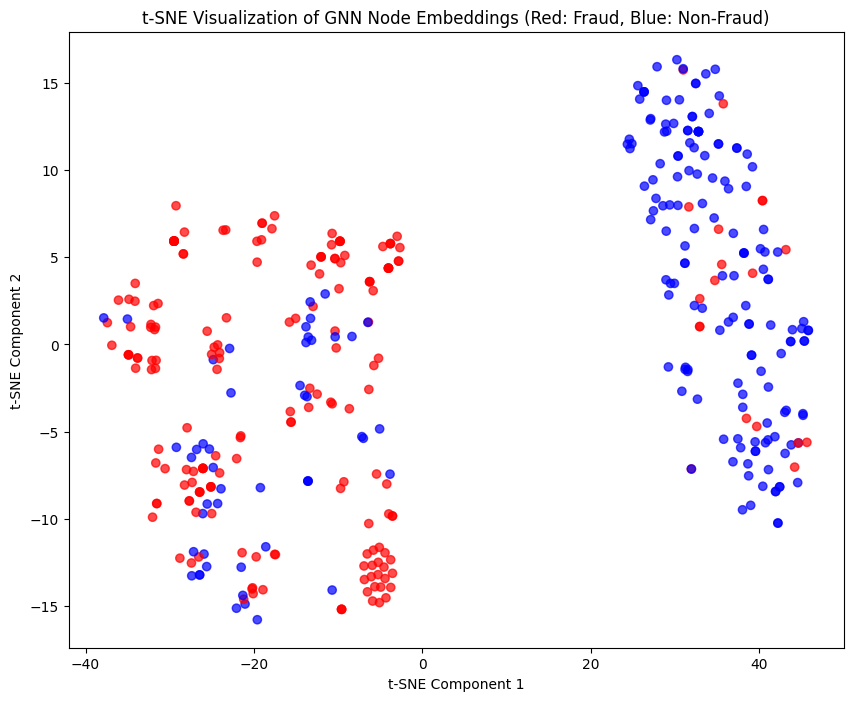

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

with torch.no_grad():
    embeddings = model.conv1(graph_data.x, graph_data.edge_index).numpy()

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

color_map = ['red' if label == 1 else 'blue' for label in graph_data.y]
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=color_map, alpha=0.7)
plt.title("t-SNE Visualization of GNN Node Embeddings (Red: Fraud, Blue: Non-Fraud)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

#Act prediction using GraphSAGE

#GraphSAGE (Graph Sample and AggregatE) is a graph neural network (GNN) model designed for inductive learning on large graphs

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import from_networkx
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from torch.optim import Adam

df_proper = pd.read_csv('/content/data (1).csv')

df_proper['Respondent'] = df_proper['Respondent'].fillna('Unknown')

df_proper['Filing Date'] = pd.to_datetime(df_proper['Filing Date'], errors='coerce')
df_proper['Decision Date'] = pd.to_datetime(df_proper['Decision Date'], errors='coerce')

df_proper['Case Duration'] = (df_proper['Decision Date'] - df_proper['Filing Date']).dt.days.fillna(0)

df_proper['Case_Status_Encoded'] = df_proper['Case Status'].astype('category').cat.codes
df_proper['Nature_of_Disposal_Encoded'] = df_proper['Nature of Disposal'].astype('category').cat.codes

df_proper['Under Act Encoded'] = pd.factorize(df_proper['Under Act'])[0]

In [ ]:
G = nx.Graph()

for i, row in df_proper.iterrows():
    G.add_node(i,
               Case_Duration=row['Case Duration'],
               Case_Status_Encoded=row['Case_Status_Encoded'],
               Nature_of_Disposal_Encoded=row['Nature_of_Disposal_Encoded'])

for i in range(len(df_proper)):
    for j in range(i + 1, len(df_proper)):
        if df_proper['Respondent'].iloc[i] == df_proper['Respondent'].iloc[j] or \
           df_proper['Nature of Disposal'].iloc[i] == df_proper['Nature of Disposal'].iloc[j]:
            G.add_edge(i, j)

graph_data = from_networkx(G)

graph_data.x = torch.tensor(df_proper[['Case Duration', 'Case_Status_Encoded', 'Nature_of_Disposal_Encoded']].values, dtype=torch.float)

graph_data.y = torch.tensor(df_proper['Under Act Encoded'].values, dtype=torch.long)


In [13]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

input_dim = graph_data.x.shape[1]
hidden_dim = 16
output_dim = len(df_proper['Under Act Encoded'].unique())

model = GraphSAGE(input_dim, hidden_dim, output_dim)

train_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(graph_data.num_nodes, dtype=torch.bool)

train_indices, test_indices = train_test_split(range(graph_data.num_nodes), test_size=0.2, random_state=42)
train_mask[train_indices] = True
test_mask[test_indices] = True

graph_data.train_mask = train_mask
graph_data.test_mask = test_mask

optimizer = Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(graph_data)
    loss = loss_fn(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model.eval()
with torch.no_grad():
    out = model(graph_data)
    pred = out.argmax(dim=1)
    correct = (pred[graph_data.test_mask] == graph_data.y[graph_data.test_mask]).sum()
    acc = int(correct) / int(graph_data.test_mask.sum())
    print(f'Test Accuracy: {acc:.4f}')


Epoch 1, Loss: 45.189884185791016
Epoch 2, Loss: 24.37953758239746
Epoch 3, Loss: 12.08431625366211
Epoch 4, Loss: 6.601441860198975
Epoch 5, Loss: 4.226454257965088
Epoch 6, Loss: 5.801462650299072
Epoch 7, Loss: 7.546263217926025
Epoch 8, Loss: 7.875936508178711
Epoch 9, Loss: 7.138583183288574
Epoch 10, Loss: 5.596977710723877
Epoch 11, Loss: 3.563816547393799
Epoch 12, Loss: 3.126586437225342
Epoch 13, Loss: 4.509066581726074
Epoch 14, Loss: 5.218276500701904
Epoch 15, Loss: 4.746158599853516
Epoch 16, Loss: 3.3244948387145996
Epoch 17, Loss: 2.1671242713928223
Epoch 18, Loss: 2.739854097366333
Epoch 19, Loss: 3.329376220703125
Epoch 20, Loss: 3.363039493560791
Epoch 21, Loss: 2.9892845153808594
Epoch 22, Loss: 3.0807883739471436
Epoch 23, Loss: 3.1006357669830322
Epoch 24, Loss: 2.7834794521331787
Epoch 25, Loss: 2.226956844329834
Epoch 26, Loss: 1.8517125844955444
Epoch 27, Loss: 2.00592303276062
Epoch 28, Loss: 2.2333335876464844
Epoch 29, Loss: 2.3902103900909424
Epoch 30, Loss

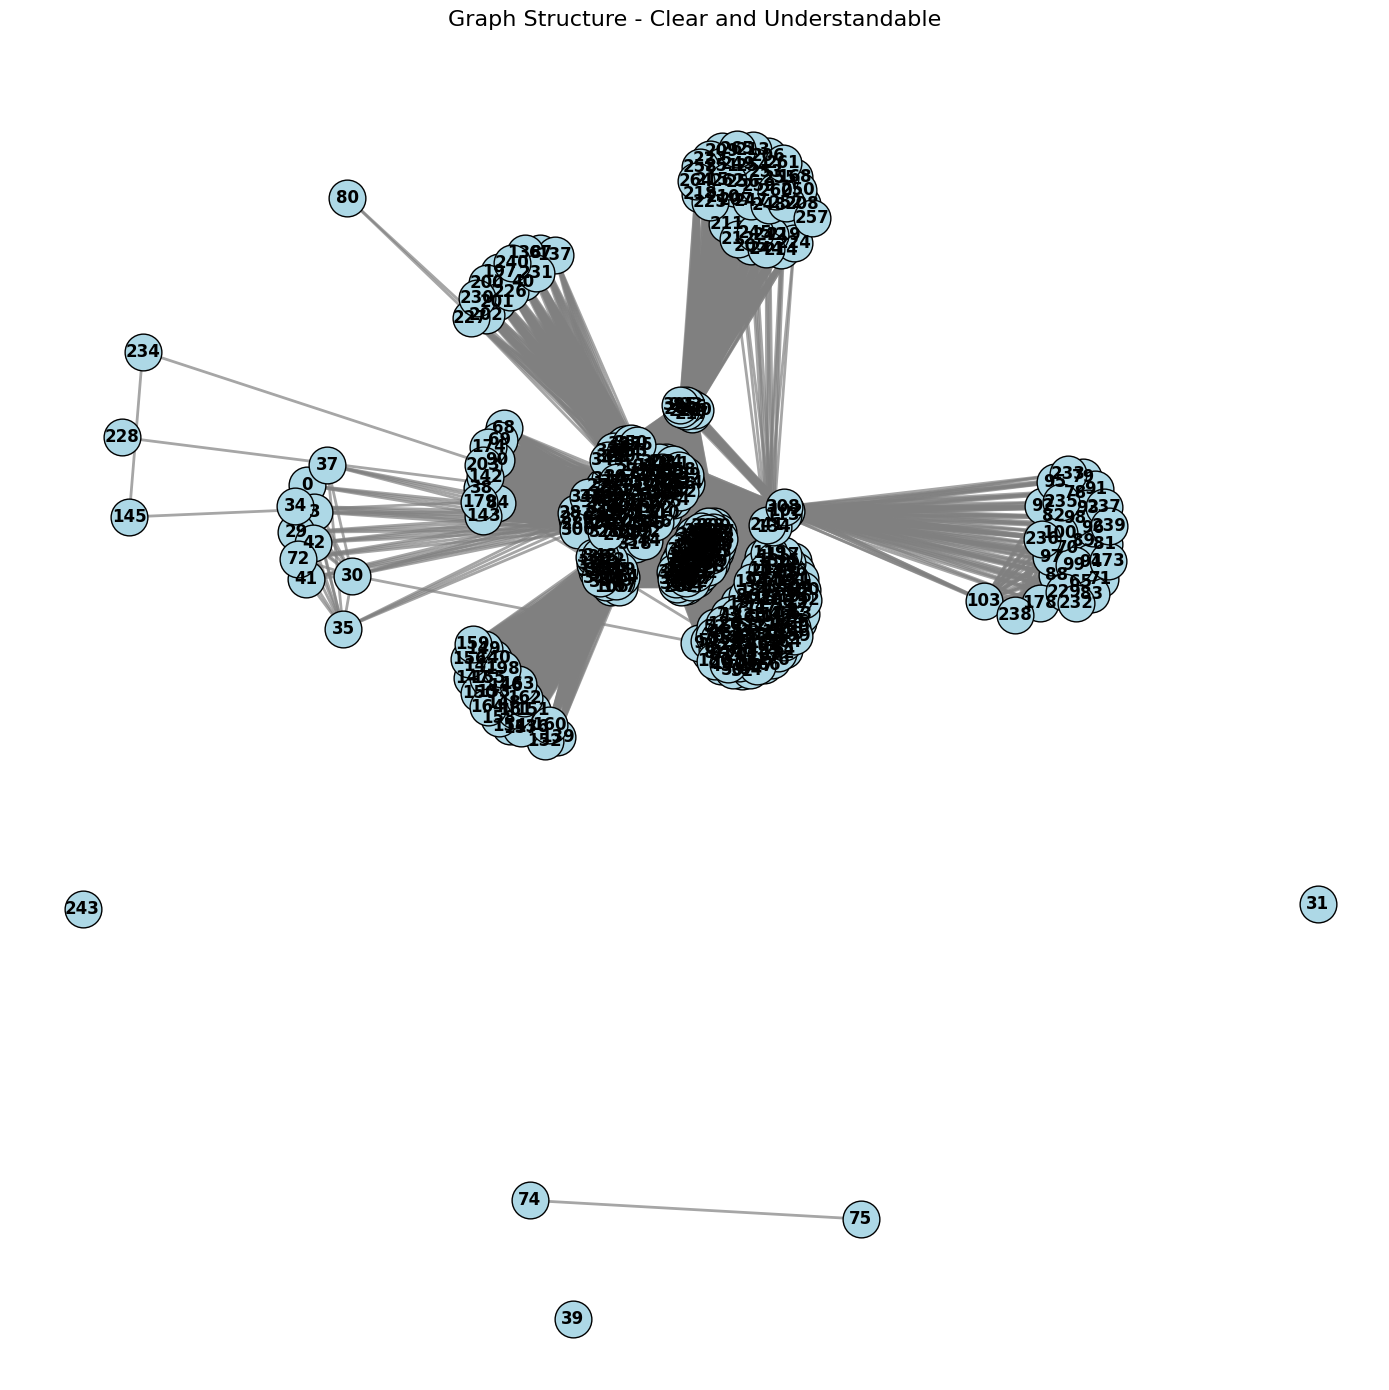

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(G):
    plt.figure(figsize=(14, 14))

    pos = nx.spring_layout(G, seed=42, k=0.3)

    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', edgecolors='black')

    nx.draw_networkx_edges(G, pos, width=2.0, alpha=0.7, edge_color='gray')

    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', font_weight='bold')

    plt.title('Graph Structure', size=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_graph(G)